In [1]:
import warnings
import pydotplus
from io import StringIO
from IPython.display import SVG
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, cross_val_score
import collections
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
warnings.filterwarnings('ignore')

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

### 简单示例练习

此小节中，我们将通过解决一个简单的示例问题来弄清楚决策树是如何工作的。虽然单颗决策树不太会产生出色的结果，但其他基于相同的思想的高性能算法（如梯度增强和随机森林）往往就威力强大了。这就需要我们先了解简单决策树的工作机制。

接下来，我们创建一个示例数据集，该数据集表示了 A 会不会和 B 进行第二次约会。而数据集中的特征包括：外貌，口才，酒精消费，以及第一次约会花了多少钱。

#### 创建示例数据集

In [3]:
# 创建示例数据集，并对数据类别进行独热编码
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out
# 保证独热编码后的特征在训练和测试数据中同时存在


def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [4]:
features = ['Looks', 'Alcoholic_beverage', 'Eloquence', 'Money_spent']

接下来，我们指定一些训练和测试数据。

#### 训练数据

In [5]:
df_train = {}
df_train['Looks'] = ['handsome', 'handsome', 'handsome', 'repulsive',
                     'repulsive', 'repulsive', 'handsome']
df_train['Alcoholic_beverage'] = [
    'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes']
df_train['Eloquence'] = ['high', 'low', 'average', 'average', 'low',
                         'high', 'average']
df_train['Money_spent'] = ['lots', 'little', 'lots', 'little', 'lots',
                           'lots', 'lots']
df_train['Will_go'] = LabelEncoder().fit_transform(
    ['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


#### 测试数据

In [6]:
df_test = {}
df_test['Looks'] = ['handsome', 'handsome', 'repulsive']
df_test['Alcoholic_beverage'] = ['no', 'yes', 'yes']
df_test['Eloquence'] = ['average', 'high', 'average']
df_test['Money_spent'] = ['lots', 'little', 'lots']
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [7]:
# 保证独热编码后的特征在训练和测试数据中同时存在
y = df_train['Will_go']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Eloquence_average,Alcoholic_beverage_no,Looks_repulsive,Eloquence_high,Money_spent_lots,Looks_handsome,Money_spent_little,Alcoholic_beverage_yes
0,0,0,0,1,1,1,0,1
1,0,0,0,0,0,1,1,1
2,1,1,0,0,1,1,0,0
3,1,1,1,0,0,0,1,0
4,0,0,1,0,1,0,0,1
5,0,0,1,1,1,0,0,1
6,1,0,0,0,1,1,0,1


In [8]:
df_test

,Eloquence_average,Alcoholic_beverage_no,Looks_repulsive,Eloquence_high,Money_spent_lots,Looks_handsome,Money_spent_little,Alcoholic_beverage_yes
0,1,1,0,0,1,1,0,0
1,0,0,0,1,0,1,1,1
2,1,0,1,0,1,0,0,1


当然，我们也可以使用 scikit-learn 提供的方法来绘制决策树。

In [9]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=17)
dt.fit(df_train, y)

DecisionTreeClassifier(criterion='entropy', random_state=17)

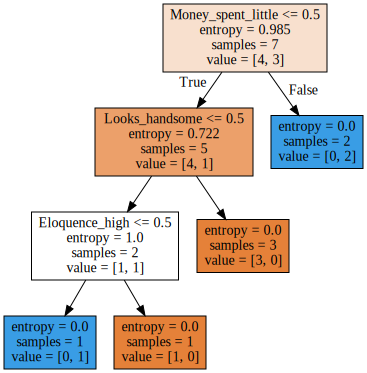

In [10]:
tree_str = export_graphviz(
    dt, feature_names=df_train.columns, out_file=None, filled=True)
graph = pydotplus.graph_from_dot_data(tree_str)
SVG(graph.create_svg())

### 计算熵和信息增益

接下来，我们换另外一个例子：假设有 9 个蓝色球和 11 个黄色球。如果球是蓝色，则让球的标签是 1，否则为 0。

In [11]:
balls = [1 for i in range(9)] + [0 for i in range(11)]  # 生成数据

接下来将球分成如下两组：

In [12]:
# 数据分组
# 8 蓝色 和 5 黄色
balls_left = [1 for i in range(8)] + [0 for i in range(5)]
# 1 蓝色 和 6 黄色
balls_right = [1 for i in range(1)] + [0 for i in range(6)]

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>请根据前面的实验内容实现香农熵计算函数 `entropy()`。

实现函数时，请结合下一题给出的测试示例，保证测试用例可以执行成功。

In [13]:
from math import log

In [14]:
balls
balls_left
balls_right

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

[1, 0, 0, 0, 0, 0, 0]

In [15]:
def entropy(dataSet):
    length, dataDict = float(len(dataSet)), {}
    for data in dataSet:
        try: dataDict[data] += 1
        except: dataDict[data] = 1
    return sum([-(d/length)*log(d/length) for d in list(dataDict.values())])

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>列表 ball_left 给出状态的熵是多少？

In [16]:
print('列表 ball_left 给出状态的熵是:{}'.format(entropy(balls_left)))

列表 ball_left 给出状态的熵是:0.666278442414676


<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>如果有一个 6 面立方体等概率骰子，其熵是多少？

In [17]:
print('如果有一个 6 面立方体等概率骰子，其熵是:{}'.format(entropy([1, 2, 3, 4, 5, 6])))

如果有一个 6 面立方体等概率骰子，其熵是:1.7917594692280547


接下来，请实现信息增益的计算函数 `information_gain(root, left, right)`。

In [18]:
def information_gain(root, left, right):
    e0 = entropy(root)
    e1 = float(len(left)/len(root)*entropy(left))
    e2 = float(len(right)/len(root)*entropy(right))
    return e0 - e1 - e2

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>将初始数据集拆分为 balls_left 和 balls_right 后的信息增益是多少？

In [19]:
information_gain(balls,balls_left,balls_right)

0.11151711474310586

接下来，我们尝试实现基于信息增益划分函数 `best_feature_to_split`。

In [20]:
def best_feature_to_split(X, y):
    '''信息增益用于特征分割'''
    out = []
    for i in X.columns:
        out.append(information_gain(y, y[X[i] == 0], y[X[i] == 1]))
    return out

然后，通过递归调用 `best_feature_to_split` 实现一个简单的树构建策略，并输出每一步的熵变化。

In [21]:
def btree(X, y):
    clf = best_feature_to_split(X, y)
    param = clf.index(max(clf))
    ly = y[X.iloc[:, param] == 0]
    ry = y[X.iloc[:, param] == 1]
    print('Column_' + str(param) + ' N/Y?')
    print('Entropy: ', entropy(ly), entropy(ry))
    print('N count:', ly.count(), '/', 'Y count:', ry.count())
    if entropy(ly) != 0:
        left = X[X.iloc[:, param] == 0]
        btree(left, ly)
    if entropy(ry) != 0:
        right = X[X.iloc[:, param] == 1]
        btree(right, ry)

In [22]:
best_feature_to_split(df_train, y)

[0.014032215111297541,
 0.004143433819589842,
 0.08878194993480437,
 0.20218548540814563,
 0.32547780217319466,
 0.08878194993480437,
 0.32547780217319466,
 0.004143433819589815]

In [23]:
btree(df_train, y)

Column_4 N/Y?
Entropy:  0.0 0.5004024235381879
N count: 2 / Y count: 5
Column_2 N/Y?
Entropy:  0.0 0.6931471805599453
N count: 3 / Y count: 2
Column_3 N/Y?
Entropy:  0.0 0.0
N count: 1 / Y count: 1


### 构建 Adult 数据集决策树

[<i class="fa fa-external-link-square" aria-hidden="true"> UCI Adult</i>](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) 人口收入普查数据集前面已经使用过了，其具有以下一些特征：

- Age – 连续数值特征
- Workclass –  连续数值特征
- fnlwgt – 连续数值特征
- Education –  类别特征
- Education_Num – 连续数值特征
- Martial_Status –  类别特征
- Occupation –  类别特征
- Relationship – 类别特征
- Race – 类别特征
- Sex – 类别特征
- Capital_Gain – 连续数值特征
- Capital_Loss – 连续数值特征
- Hours_per_week – 连续数值特征
- Country – 类别特征

- Target – 收入水平，二元分类目标值

接下来，我们加载并读取该数据集：

In [24]:
data_train = pd.read_csv(
    'adult_train.csv', sep=';')

In [25]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [26]:
data_test = pd.read_csv(
    'adult_test.csv', sep=';')

In [27]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


然后，对数据集进行一些必要的清洗。同时，将目标值转换为 0，1 二元数值。

In [28]:
# 移除测试集中的错误数据
data_test = data_test[(data_test['Target'] == ' >50K.')
                      | (data_test['Target'] == ' <=50K.')]

# 将目标编码为 0 和 1
data_train.loc[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.loc[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.loc[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target'] == ' >50K.', 'Target'] = 1

输出测试数据概览表，查看特征和目标值的各项统计指标。

In [29]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


接下来，查看训练数据集目标分布计数，同时绘制各项特征的关联分布图像。

In [30]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

Text(0.5, 1.0, 'Age')

<AxesSubplot:title={'center':'Age'}>

(array([  0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Workclass')

<AxesSubplot:title={'center':'Workclass'}>

Text(0.5, 1.0, 'fnlwgt')

<AxesSubplot:title={'center':'fnlwgt'}>

(array([-250000.,       0.,  250000.,  500000.,  750000., 1000000.,
        1250000., 1500000., 1750000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Education')

<AxesSubplot:title={'center':'Education'}>

Text(0.5, 1.0, 'Education_Num')

<AxesSubplot:title={'center':'Education_Num'}>

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Martial_Status')

<AxesSubplot:title={'center':'Martial_Status'}>

Text(0.5, 1.0, 'Occupation')

<AxesSubplot:title={'center':'Occupation'}>

Text(0.5, 1.0, 'Relationship')

<AxesSubplot:title={'center':'Relationship'}>

Text(0.5, 1.0, 'Race')

<AxesSubplot:title={'center':'Race'}>

Text(0.5, 1.0, 'Sex')

<AxesSubplot:title={'center':'Sex'}>

Text(0.5, 1.0, 'Capital_Gain')

<AxesSubplot:title={'center':'Capital_Gain'}>

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.,
        120000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Capital_Loss')

<AxesSubplot:title={'center':'Capital_Loss'}>

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Hours_per_week')

<AxesSubplot:title={'center':'Hours_per_week'}>

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'Country')

<AxesSubplot:title={'center':'Country'}>

Text(0.5, 1.0, 'Target')

<AxesSubplot:title={'center':'Target'}>

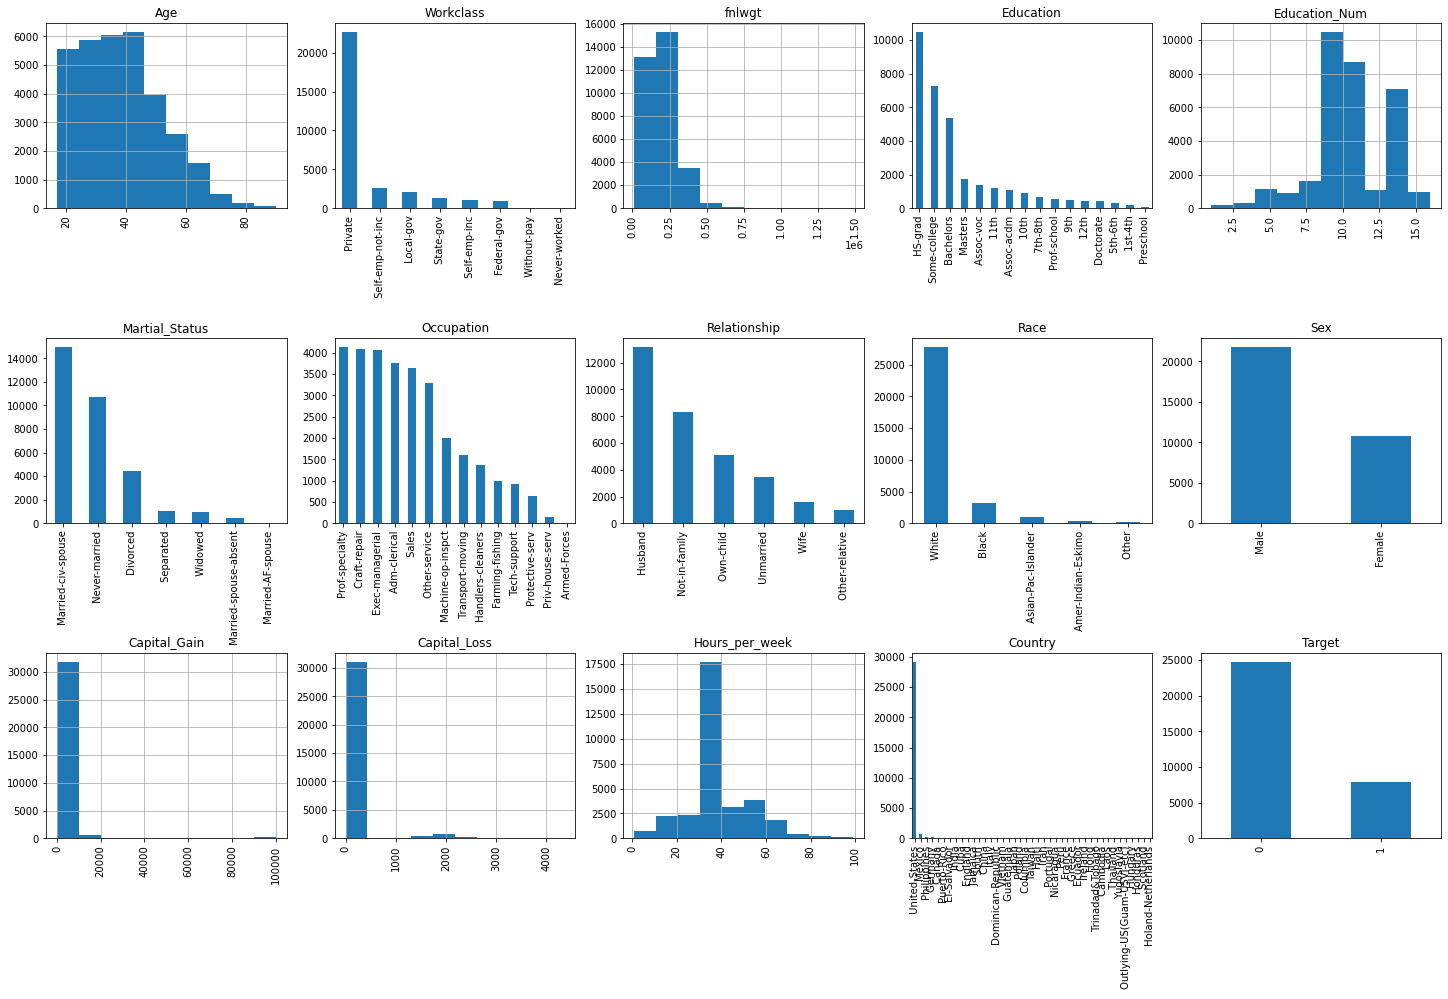

In [31]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

进一步分析之前，需要检查数据的类型。

In [32]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [33]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

可以看的测试数据中，年龄 Age 是 object 类型，我们需要修复其为整数类型。

In [34]:
data_test['Age'] = data_test['Age'].astype(int)

与此同时，我们将测试数据中浮点类型特征全部处理成整数类型，以便与训练数据对应。

In [35]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

这里还需要继续对数据预处理，首先区分数据集中的类别和连续特征。

In [36]:
# 从数据集中选择类别和连续特征变量
categorical_columns = [c for c in data_train.columns
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns
                     if data_train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


然后，对连续特征使用中位数对缺失数据进行填充，而类别特征则使用众数进行填充。

In [37]:
# 填充缺失数据
for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode(), inplace=True)
    data_test[c].fillna(data_train[c].mode(), inplace=True)

for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

接下来，我们需要对类别特征进行独热编码，以保证数据集特征全部为数值类型方便后续传入模型。

In [38]:
data_train = pd.concat([data_train[numerical_columns],
                        pd.get_dummies(data_train[categorical_columns])], axis=1)

data_test = pd.concat([data_test[numerical_columns],
                       pd.get_dummies(data_test[categorical_columns])], axis=1)

In [39]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [40]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

独热编码之后发现测试数据中没有 Holland，为了与训练数据对应，这里需要创建零值特征进行补齐。

In [41]:
data_test['Country_ Holand-Netherlands'] = 0

In [42]:
set(data_train.columns) - set(data_test.columns)

set()

In [43]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [44]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [45]:
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

### 建立默认参数决策树模型

接下来，使用训练数据创建一个决策树分类器。挑战规定 `max_depth=3`，`random_state=17`。

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>按挑战要求构建决策树，并输出其在测试集上的准确度？

In [46]:
clf = DecisionTreeClassifier(max_depth=3,random_state=17)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

In [47]:
pre = clf.predict(X_test)
accuracy_score(y_test,pre)

0.8447884036607088

### 对决策树模型进行调参

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>使用 GridSearchCV 网格搜索对决策树进行调参并返回最佳参数。

挑战规定，决策树参数 `random_state = 17`，GridSearchCV 参数 `cv=5`，并对 `max_depth` 参数在 $[8, 10]$ 范围进行网格搜索。

In [48]:
tree_params = {'max_depth': range(8, 11)} 
best_tree = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, cv=5)
best_tree.fit(X_train, y_train) 
GridSearchCV(cv=5, error_score='raise-deprecating', estimator=DecisionTreeClassifier(class_weight=None, criterion='gini',max_depth=None, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=17, splitter='best'),iid='warn', n_jobs=None, param_grid={'max_depth': range(8, 11)}, pre_dispatch='2*n_jobs', refit=True, return_train_score='warn', scoring=None, verbose=0)
print("Best params:", best_tree.best_params_) 
print("Best cross validaton score", best_tree.best_score_)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17),
             param_grid={'max_depth': range(8, 11)})

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(presort=False, random_state=17),
             iid='warn', param_grid={'max_depth': range(8, 11)},
             return_train_score='warn')

Best params: {'max_depth': 9}
Best cross validaton score 0.8562698879315647


<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>构建上面最佳参数决策树，并输出其在测试集上的准确度？

In [49]:
new_tree = DecisionTreeClassifier(max_depth=9,random_state=17) 
new_tree.fit(X_train, y_train)
new_tree_pre = new_tree.predict(X_test) 
accuracy_score(y_test, new_tree_pre) 

DecisionTreeClassifier(max_depth=9, random_state=17)

0.8471838339168356

---